# General data set analysis

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

blinds = np.loadtxt('blinds.txt')

def apply_blinds_fp(input_df, blinds):
    output_df = input_df.copy()
    for m in range(6):
        stms = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        output_df[stms] = output_df[stms] + blinds[m]
    return output_df

def apply_blinds_tr(input_df, blinds):
    output_df = input_df.copy()
    for m in range(6):
        stms = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        output_df[stms] = output_df[stms] + blinds[m]
        trms = ['tr,m'+str(m+1)]
        output_df[trms] = output_df[trms] + blinds[m]
    return output_df

def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=3)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':12, 'family':'serif'})

Welcome to JupyROOT 6.12/04


## Low Kick Data Set

In [ ]:
%%time

## High Kick Data Set

print 'fp run 1'
fp_moment_df_1 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/lowkick.h5', 'fp_df_1')), blinds)

print 'tr run 1'
tr_moment_df_1 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/lowkick.h5', 'tr_df_1')), blinds)
print 'tr run 2'
tr_moment_df_2 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/lowkick.h5', 'tr_df_2')), blinds)

In [ ]:
tr_corr_df_1 = helper_old.trolley_footprint_replacement(tr_moment_df_1)
tr_corr_df_2 = helper_old.trolley_footprint_replacement(tr_moment_df_2)

tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, summed_pts_1 = helper_old.trolley_run_station_average(tr_corr_df_1)
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, summed_pts_2 = helper_old.trolley_run_station_average(tr_corr_df_2)

vtm_df_1 = helper.vtm_calc(fp_moment_df_1,
                           baseline_time_1, baseline_time_2,
                           tr_baseline_1, tr_baseline_2,
                           fp_baseline_1, fp_baseline_2)

start = np.ceil(vtm_df_1.index.values[0]/100)*100
end = np.floor(vtm_df_1.index.values[-1]/100)*100 + 100
bins_1 = np.arange(start, end, 100)  # bin edges
bin_centers_1 = np.arange(start, end-100, 100)+50

vtm_bin_df_1 = vtm_df_1.groupby(pd.cut(vtm_df_1.index, bins_1)).mean()
vtm_bin_df_1.index = bin_centers_1

vtm_bin_df_full = vtm_bin_df_1.copy()

azi_avg_df = pd.DataFrame(np.zeros((vtm_bin_df_full.shape[0],6)),
                         index = vtm_bin_df_full.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = summed_azimuth_1[:, m] + summed_azimuth_2[:, m]
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = vtm_bin_df_full[stm_list].multiply(weight).sum(axis=1)/total_weight
    
print_df = azi_avg_df[['m1','m2','m3','m4','m5']].copy()/61.79
print_df['m1_err'] = -1
print_df['m2_err'] = -1
print_df['m3_err'] = -1
print_df['m5_err'] = -1

print_df = print_df.sort_index(axis='columns')
# print_df.head()
# print_df.to_csv('purcell_60hr_7-31.csv')

In [ ]:
sync_offsets_1, delta_time_1 = helper.sync_offset_calc(tr_corr_df_1, tr_corr_df_2)

In [ ]:
def gaussian(x, A, x0, s): return A * np.exp(-(x-x0)**2/(2*s**2))

m = 5

out = plt.hist(sync_offsets_1[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total = fit[2]**2/4 * np.mean(delta_time_1)
weight = np.mean(delta_time_1)

print np.sqrt(running_total/weight)
print np.sqrt(running_total/weight)/61.79e6*1e9
print np.sqrt(running_total/weight)/61.79e6*1e9/np.sqrt(72)

In [ ]:
sns.set_style('darkgrid')

fig2, ax2 = plt.subplots(1,1)
m = 1
ax2.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax2.set_ylabel('$m_'+str(m)+'$-61.74 MHz (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax2)
fig2.set_size_inches(6,3)
fig2.tight_layout()
fig2.savefig('lowkick_m'+str(m)+'.png', dpi=300)


fig3, ax3 = plt.subplots(1,1)
m = 2
ax3.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax3.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax3)
fig3.set_size_inches(6,3)
fig3.tight_layout()
fig3.savefig('lowkick_m'+str(m)+'.png', dpi=300)

fig4, ax4 = plt.subplots(1,1)
m = 3
ax4.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax4.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax4)
fig4.set_size_inches(6,3)
fig4.tight_layout()
fig4.savefig('lowkick_m'+str(m)+'.png', dpi=300)

fig5, ax5 = plt.subplots(1,1)
m = 4
ax5.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax5.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax5)
fig5.set_size_inches(6,3)
fig5.tight_layout()
fig5.savefig('lowkick_m'+str(m)+'.png', dpi=300)

fig6, ax6 = plt.subplots(1,1)
m = 5
ax6.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax6.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax6)
fig6.set_size_inches(6,3)
fig6.tight_layout()
fig6.savefig('lowkick_m'+str(m)+'.png', dpi=300)

In [ ]:
plt.plot(print_df.index.values, print_df['m2'], '.')
# plt.xlim((1526455000, 1526475000))
# plt.ylim(842,845)
ax = plt.gca()
fig = plt.gcf()

plt2.plt_unix_time_to_CST(ax)

ax.set_ylabel('n quad (ppm)')

fig.set_size_inches(12,6)
fig.tight_layout()

In [ ]:
## look at naive trolley avg

print np.dot(tr_baseline_1[:,0],summed_azimuth_1[:,0])/np.sum(summed_azimuth_1[:,0])/61.79

## High Kick Data Set

In [2]:
%%time

## High Kick Data Set

print 'fp run 1'
fp_moment_df_1 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/highkick.h5', 'fp_df_1')), blinds)
print 'fp run 2'
fp_moment_df_2 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/highkick.h5', 'fp_df_2')), blinds)

print 'tr run 1'
tr_moment_df_1 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/highkick.h5', 'tr_df_1')), blinds)
print 'tr run 2'
tr_moment_df_2 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/highkick.h5', 'tr_df_2')), blinds)
print 'tr run 3'
tr_moment_df_3 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/highkick.h5', 'tr_df_3')), blinds)

fp run 1
Finished calculating all moments for 251685 events. 
fp run 2
Finished calculating all moments for 221219 events.
tr run 1
Finished calculating all moments for 4351 events.
tr run 2
Finished calculating all moments for 4372 events.
tr run 3
Finished calculating all moments for 4344 events.
CPU times: user 36.7 s, sys: 1min 11s, total: 1min 48s
Wall time: 17 s


In [3]:
tr_corr_df_1 = helper_old.trolley_footprint_replacement(tr_moment_df_1)
tr_corr_df_2 = helper_old.trolley_footprint_replacement(tr_moment_df_2)
tr_corr_df_3 = helper_old.trolley_footprint_replacement(tr_moment_df_3)

tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, summed_pts_1 = helper_old.trolley_run_station_average(tr_corr_df_1)
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, summed_pts_2 = helper_old.trolley_run_station_average(tr_corr_df_2)
tr_baseline_3, fp_baseline_3, baseline_time_3, summed_azimuth_3, summed_pts_3 = helper_old.trolley_run_station_average(tr_corr_df_3)

vtm_df_1 = helper.vtm_calc(fp_moment_df_1,
                           baseline_time_1, baseline_time_2,
                           tr_baseline_1, tr_baseline_2,
                           fp_baseline_1, fp_baseline_2)

vtm_df_2 = helper.vtm_calc(fp_moment_df_2,
                           baseline_time_2, baseline_time_3,
                           tr_baseline_2, tr_baseline_3,
                           fp_baseline_2, fp_baseline_3)

start = np.ceil(vtm_df_1.index.values[0]/100)*100
end = np.floor(vtm_df_1.index.values[-1]/100)*100 + 100
bins_1 = np.arange(start, end, 100)  # bin edges
bin_centers_1 = np.arange(start, end-100, 100)+50

start = np.ceil(vtm_df_2.index.values[0]/100)*100
end = np.floor(vtm_df_2.index.values[-1]/100)*100 + 100
bins_2 = np.arange(start, end, 100)  # bin edges
bin_centers_2 = np.arange(start, end-100, 100)+50

vtm_bin_df_1 = vtm_df_1.groupby(pd.cut(vtm_df_1.index, bins_1)).mean()
vtm_bin_df_1.index = bin_centers_1
vtm_bin_df_2 = vtm_df_2.groupby(pd.cut(vtm_df_2.index, bins_2)).mean()
vtm_bin_df_2.index = bin_centers_2

vtm_bin_df_full = vtm_bin_df_1.copy()
vtm_bin_df_full = vtm_bin_df_full.append(vtm_bin_df_2)

azi_avg_df = pd.DataFrame(np.zeros((vtm_bin_df_full.shape[0],6)),
                         index = vtm_bin_df_full.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = summed_azimuth_1[:, m] + summed_azimuth_2[:, m] + summed_azimuth_3[:, m]
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = vtm_bin_df_full[stm_list].multiply(weight).sum(axis=1)/total_weight
    
print_df = azi_avg_df[['m1','m2','m3','m4','m5']].copy()/61.79
print_df['m1_err'] = -1
print_df['m2_err'] = -1
print_df['m3_err'] = -1
print_df['m5_err'] = -1

print_df = print_df.sort_index(axis='columns')
# print_df.head()
# print_df.to_csv('purcell_60hr_7-31.csv')

Removing trolley image from station 71.                                   


In [4]:
sync_offsets_1, delta_time_1 = helper.sync_offset_calc(tr_corr_df_1, tr_corr_df_2)
sync_offsets_2, delta_time_2 = helper.sync_offset_calc(tr_corr_df_2, tr_corr_df_3)

3.3151133086100857
53.651291610456155


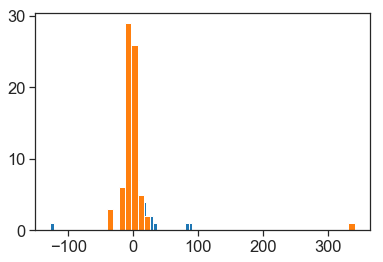

In [6]:
def gaussian(x, A, x0, s): return A * np.exp(-(x-x0)**2/(2*s**2))

m = 5

out = plt.hist(sync_offsets_1[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total = fit[2]**2/4 * np.mean(delta_time_1)
weight = np.mean(delta_time_1)


out = plt.hist(sync_offsets_2[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total += fit[2]**2/4 * np.mean(delta_time_2)
weight += np.mean(delta_time_2)

print np.sqrt(running_total/weight)
print np.sqrt(running_total/weight)/61.79e6*1e9

In [ ]:
sns.set_style('darkgrid')

fig2, ax2 = plt.subplots(1,1)
m = 1
ax2.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax2.set_ylabel('$m_'+str(m)+'$-61.74 MHz (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax2)
fig2.set_size_inches(6,3)
fig2.tight_layout()
fig2.savefig('highkick_m'+str(m)+'.png', dpi=300)


fig3, ax3 = plt.subplots(1,1)
m = 2
ax3.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax3.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax3)
fig3.set_size_inches(6,3)
fig3.tight_layout()
fig3.savefig('highkick_m'+str(m)+'.png', dpi=300)

fig4, ax4 = plt.subplots(1,1)
m = 3
ax4.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax4.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax4)
fig4.set_size_inches(6,3)
fig4.tight_layout()
fig4.savefig('highkick_m'+str(m)+'.png', dpi=300)

fig5, ax5 = plt.subplots(1,1)
m = 4
ax5.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax5.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax5)
fig5.set_size_inches(6,3)
fig5.tight_layout()
fig5.savefig('highkick_m'+str(m)+'.png', dpi=300)

fig6, ax6 = plt.subplots(1,1)
m = 5
ax6.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax6.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax6)
fig6.set_size_inches(6,3)
fig6.tight_layout()
fig6.savefig('highkick_m'+str(m)+'.png', dpi=300)

In [ ]:
plt.plot(print_df.index.values, print_df['m1'], '.')
# plt.xlim((1525117000, 1525120000))
plt.ylim(840.5,844)
ax = plt.gca()
fig = plt.gcf()

ax.set_ylabel('dipole (ppm)')
plt2.plt_unix_time_to_CST(ax)

fig.set_size_inches(12,6)
fig.tight_layout()

## End Game Data Set

In [ ]:
%%time

print 'fp run 1'
fp_moment_df_1 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'fp_df_1')), blinds)
print 'fp run 2'
fp_moment_df_2 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'fp_df_2')), blinds)
print 'fp run 3'
fp_moment_df_3 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'fp_df_3')), blinds)
print 'fp run 4'
fp_moment_df_4 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'fp_df_4')), blinds)
print 'fp run 5'
fp_moment_df_5 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'fp_df_5')), blinds)
print 'fp run 6'
fp_moment_df_6 = apply_blinds_fp(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'fp_df_6')), blinds)

print 'tr run 1'
tr_moment_df_1 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_1')), blinds)
print 'tr run 2'
tr_moment_df_2 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_2')), blinds)
print 'tr run 3'
tr_moment_df_3 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_3')), blinds)
print 'tr run 4'
tr_moment_df_4 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_4')), blinds)
print 'tr run 5'
tr_moment_df_5 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_5')), blinds)
print 'tr run 6'
tr_moment_df_6 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_6')), blinds)
print 'tr run 7'
tr_moment_df_7 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_7')), blinds)
print 'tr run 8'
tr_moment_df_8 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_8')), blinds)
print 'tr run 9'
tr_moment_df_9 = apply_blinds_tr(helper.calc_moment_df(pd.read_hdf('hdf5/endgame.h5', 'tr_df_9')), blinds)

In [ ]:
## FIRST TROLLEY PAIR IS DROPPED

# tr_corr_df_1 = helper_old.trolley_footprint_replacement(tr_moment_df_1)
tr_corr_df_2 = helper_old.trolley_footprint_replacement(tr_moment_df_2)
tr_corr_df_3 = helper_old.trolley_footprint_replacement(tr_moment_df_3)
tr_corr_df_4 = helper_old.trolley_footprint_replacement(tr_moment_df_4)
tr_corr_df_5 = helper_old.trolley_footprint_replacement(tr_moment_df_5)
tr_corr_df_6 = helper_old.trolley_footprint_replacement(tr_moment_df_6)
tr_corr_df_7 = helper_old.trolley_footprint_replacement(tr_moment_df_7)
tr_corr_df_8 = helper_old.trolley_footprint_replacement(tr_moment_df_8)
# tr_corr_df_9 = helper_old.trolley_footprint_replacement(tr_moment_df_9)

# tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, summed_pts_1 = helper_old.trolley_run_station_average(tr_corr_df_1)
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, summed_pts_2 = helper_old.trolley_run_station_average(tr_corr_df_2)
tr_baseline_3, fp_baseline_3, baseline_time_3, summed_azimuth_3, summed_pts_3 = helper_old.trolley_run_station_average(tr_corr_df_3)

tr_baseline_4, fp_baseline_4, baseline_time_4, summed_azimuth_4, summed_pts_4 = helper_old.trolley_run_station_average(tr_corr_df_4)
tr_baseline_5, fp_baseline_5, baseline_time_5, summed_azimuth_5, summed_pts_5 = helper_old.trolley_run_station_average(tr_corr_df_5)
tr_baseline_6, fp_baseline_6, baseline_time_6, summed_azimuth_6, summed_pts_6 = helper_old.trolley_run_station_average(tr_corr_df_6)

tr_baseline_7, fp_baseline_7, baseline_time_7, summed_azimuth_7, summed_pts_7 = helper_old.trolley_run_station_average(tr_corr_df_7)
tr_baseline_8, fp_baseline_8, baseline_time_8, summed_azimuth_8, summed_pts_8 = helper_old.trolley_run_station_average(tr_corr_df_8)
# tr_baseline_9, fp_baseline_9, baseline_time_9, summed_azimuth_9, summed_pts_9 = helper_old.trolley_run_station_average(tr_corr_df_9)

## vtm_df_1 will have weirdness due to SCC shenanigans
# vtm_df_1 = helper.vtm_calc(fp_moment_df_1,
#                            baseline_time_1, baseline_time_2,  ## only backwards track?
#                            tr_baseline_2, tr_baseline_2,
#                            fp_baseline_2, fp_baseline_2)

vtm_df_2 = helper.vtm_calc(fp_moment_df_2,
                           baseline_time_2, baseline_time_3,
                           tr_baseline_2, tr_baseline_3,
                           fp_baseline_2, fp_baseline_3)

vtm_df_3 = helper.vtm_calc(fp_moment_df_3,
                           baseline_time_4, baseline_time_5,
                           tr_baseline_4, tr_baseline_5,
                           fp_baseline_4, fp_baseline_5)

vtm_df_4 = helper.vtm_calc(fp_moment_df_4,
                           baseline_time_6, baseline_time_7,
                           tr_baseline_6, tr_baseline_7,
                           fp_baseline_6, fp_baseline_7)

vtm_df_5 = helper.vtm_calc(fp_moment_df_5,
                           baseline_time_7, baseline_time_8,
                           tr_baseline_7, tr_baseline_8,
                           fp_baseline_7, fp_baseline_8)

vtm_df_6 = helper.vtm_calc(fp_moment_df_6,
                           baseline_time_8, baseline_time_7,  # NO BACKWARDS TRACKING
                           tr_baseline_8, tr_baseline_8,
                           fp_baseline_8, fp_baseline_8)

# start = np.ceil(vtm_df_1.index.values[0]/100)*100
# end = np.floor(vtm_df_1.index.values[-1]/100)*100 + 100
# bins_1 = np.arange(start, end, 100)  # bin edges
# bin_centers_1 = np.arange(start, end-100, 100)+50

start = np.ceil(vtm_df_2.index.values[0]/100)*100
end = np.floor(vtm_df_2.index.values[-1]/100)*100 + 100
bins_2 = np.arange(start, end, 100)  # bin edges
bin_centers_2 = np.arange(start, end-100, 100)+50

start = np.ceil(vtm_df_3.index.values[0]/100)*100
end = np.floor(vtm_df_3.index.values[-1]/100)*100 + 100
bins_3 = np.arange(start, end, 100)  # bin edges
bin_centers_3 = np.arange(start, end-100, 100)+50

start = np.ceil(vtm_df_4.index.values[0]/100)*100
end = np.floor(vtm_df_4.index.values[-1]/100)*100 + 100
bins_4 = np.arange(start, end, 100)  # bin edges
bin_centers_4 = np.arange(start, end-100, 100)+50

start = np.ceil(vtm_df_5.index.values[0]/100)*100
end = np.floor(vtm_df_5.index.values[-1]/100)*100 + 100
bins_5 = np.arange(start, end, 100)  # bin edges
bin_centers_5 = np.arange(start, end-100, 100)+50

start = np.ceil(vtm_df_6.index.values[0]/100)*100
end = np.floor(vtm_df_6.index.values[-1]/100)*100 + 100
bins_6 = np.arange(start, end, 100)  # bin edges
bin_centers_6 = np.arange(start, end-100, 100)+50

# vtm_bin_df_1 = vtm_df_1.groupby(pd.cut(vtm_df_1.index, bins_1)).mean()
# vtm_bin_df_1.index = bin_centers_1
vtm_bin_df_2 = vtm_df_2.groupby(pd.cut(vtm_df_2.index, bins_2)).mean()
vtm_bin_df_2.index = bin_centers_2
vtm_bin_df_3 = vtm_df_3.groupby(pd.cut(vtm_df_3.index, bins_3)).mean()
vtm_bin_df_3.index = bin_centers_3
vtm_bin_df_4 = vtm_df_4.groupby(pd.cut(vtm_df_4.index, bins_4)).mean()
vtm_bin_df_4.index = bin_centers_4
vtm_bin_df_5 = vtm_df_5.groupby(pd.cut(vtm_df_5.index, bins_5)).mean()
vtm_bin_df_5.index = bin_centers_5
vtm_bin_df_6 = vtm_df_6.groupby(pd.cut(vtm_df_6.index, bins_6)).mean()
vtm_bin_df_6.index = bin_centers_6

# vtm_bin_df_full = vtm_bin_df_1.copy()
# vtm_bin_df_full = vtm_bin_df_full.append(vtm_bin_df_2)
vtm_bin_df_full = vtm_bin_df_2.copy()
vtm_bin_df_full = vtm_bin_df_full.append(vtm_bin_df_3)
vtm_bin_df_full = vtm_bin_df_full.append(vtm_bin_df_4)
vtm_bin_df_full = vtm_bin_df_full.append(vtm_bin_df_5)
vtm_bin_df_full = vtm_bin_df_full.append(vtm_bin_df_6)

azi_avg_df = pd.DataFrame(np.zeros((vtm_bin_df_full.shape[0],6)),
                         index = vtm_bin_df_full.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = (summed_azimuth_2[:, m] + summed_azimuth_3[:, m]
             + summed_azimuth_4[:, m] + summed_azimuth_5[:, m] + summed_azimuth_6[:, m]
             + summed_azimuth_7[:, m] + summed_azimuth_8[:, m])# + summed_azimuth_9[:, m])
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = vtm_bin_df_full[stm_list].multiply(weight).sum(axis=1)/total_weight
    
print_df = azi_avg_df[['m1','m2','m3','m4','m5']].copy()/61.79
print_df['m1_err'] = -1
print_df['m2_err'] = -1
print_df['m3_err'] = -1
print_df['m5_err'] = -1

print_df = print_df.sort_index(axis='columns')
# print_df.head()
# print_df.to_csv('purcell_60hr_7-31.csv')

In [ ]:
sync_offsets_1, delta_time_1 = helper.sync_offset_calc(tr_corr_df_2, tr_corr_df_3)
sync_offsets_2, delta_time_2 = helper.sync_offset_calc(tr_corr_df_4, tr_corr_df_5)
sync_offsets_3, delta_time_3 = helper.sync_offset_calc(tr_corr_df_6, tr_corr_df_7)
sync_offsets_4, delta_time_4 = helper.sync_offset_calc(tr_corr_df_7, tr_corr_df_8)

In [ ]:
def gaussian(x, A, x0, s): return A * np.exp(-(x-x0)**2/(2*s**2))

m = 4

out = plt.hist(sync_offsets_1[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total = fit[2]**2/4 * np.mean(delta_time_1)
weight = np.mean(delta_time_1)


out = plt.hist(sync_offsets_2[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total += fit[2]**2/4 * np.mean(delta_time_2)
weight += np.mean(delta_time_2)


out = plt.hist(sync_offsets_3[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total += fit[2]**2/4 * np.mean(delta_time_3)
weight += np.mean(delta_time_3)


out = plt.hist(sync_offsets_4[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total += fit[2]**2/4 * np.mean(delta_time_4)
weight += np.mean(delta_time_4)

out = plt.hist(sync_offsets_4[:,m-1], bins=40)
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

running_total += fit[2]**2/2 * np.mean(delta_time_4)
weight += np.mean(delta_time_4)

print np.sqrt(running_total/weight)
print np.sqrt(running_total/weight)/61.79e6*1e9

In [ ]:
sns.set_style('darkgrid')

fig2, ax2 = plt.subplots(1,1)
m = 1
ax2.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax2.set_ylabel('$m_'+str(m)+'$-61.74 MHz (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax2)
fig2.set_size_inches(6,3)
fig2.tight_layout()
fig2.savefig('endgame_m'+str(m)+'.png', dpi=300)


fig3, ax3 = plt.subplots(1,1)
m = 2
ax3.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax3.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax3)
fig3.set_size_inches(6,3)
fig3.tight_layout()
fig3.savefig('endgame_m'+str(m)+'.png', dpi=300)

fig4, ax4 = plt.subplots(1,1)
m = 3
ax4.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax4.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax4)
fig4.set_size_inches(6,3)
fig4.tight_layout()
fig4.savefig('endgame_m'+str(m)+'.png', dpi=300)

fig5, ax5 = plt.subplots(1,1)
m = 4
ax5.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax5.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax5)
fig5.set_size_inches(6,3)
fig5.tight_layout()
fig5.savefig('endgame_m'+str(m)+'.png', dpi=300)

fig6, ax6 = plt.subplots(1,1)
m = 5
ax6.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax6.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax6)
fig6.set_size_inches(6,3)
fig6.tight_layout()
fig6.savefig('endgame_m'+str(m)+'.png', dpi=300)

In [ ]:
plt.plot(print_df.index.values, print_df['m1'], '.')
# plt.xlim((1528650000, 1529000000))
plt.ylim(843,845)
# plt.ylim(-1,1)
ax = plt.gca()
fig = plt.gcf()

ax.set_ylabel('dipole (ppm)')
plt2.plt_unix_time_to_CST(ax)

fig.set_size_inches(12,6)
fig.tight_layout()

## Other

In [ ]:
sync_offsets, delta_t = helper.sync_offset_calc(tr_corr_df_5, tr_corr_df_6)

def gaussian(x, A, x0, sigma): return A*np.exp(-(x-x0)**2/2./sigma**2)

fig, axs = plt.subplots(2,3)
for i in range(2):
    for j in range(3):
        st = 3*i+j
        if st == 5: continue
            
        plt.sca(axs[i,j])
        hist, bins, _ = plt.hist(sync_offsets[:,st], bins=50)
        low, high = axs[i,j].get_xlim()
                
        bins = bins[0:-1] + 0.5*(bins[1]-bins[0])
        coeffs, _ = curve_fit(gaussian, bins, hist, p0=[1., 0., 10.])
        fit = gaussian(np.arange(low, high, 0.1), coeffs[0], coeffs[1], coeffs[2])
        plt.plot(np.arange(low,high,0.1), fit, label=r'$\omega_0$ = '+str(np.round(coeffs[1],1))+'\n$\sigma$ = '+str(np.round(coeffs[2],1)))
        plt.legend(loc=1)
        plt2.plt_set_labels(axs[i,j], 'sync offset (Hz)', '', 'm '+str(st+1))
        
        if st == 0: plt.xlim(-100,100)
        else: plt.xlim(-50,50)


fig.set_size_inches(12,8)
fig.tight_layout()

In [ ]:
print np.mean(sync_offsets_1[:,0])/61.79
print np.std(sync_offsets_1[:,0])/61.79
print np.std(sync_offsets_1[:,0])/61.79/np.sqrt(72)

plt.hist(sync_offsets_1[:,0]/61.7, bins=50)

In [ ]:
print np.mean(sync_offsets_1[:,0])/61.79
print np.std(sync_offsets_1[:,0])/61.79
print np.std(sync_offsets_1[:,0])/61.79/np.sqrt(72)

plt.hist(sync_offsets_1[:,0]/61.7, bins=50)